In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import sklearn.model_selection as skm

import plotly.graph_objects as go


## Part 1 1 (Observational) - Generate PLS Model from Data

In [ ]:
def make_batch_level_matrix_pandas(pls_scores_df,
                                   batch_col='batch_id',
                                   time_col='batch_time_h',
                                   comp_prefix='comp_'):
    # 1) find component columns
    comp_cols = [c for c in pls_scores_df.columns if c.startswith(comp_prefix)]

    # 2) melt to long: one row per (batch, time, component)
    long = pls_scores_df.melt(
        id_vars=[batch_col, time_col],
        value_vars=comp_cols,
        var_name='component',
        value_name='score'
    )

    # 3) pivot: rows = batch, columns = (component, time)
    wide = (
        long
        .pivot(index=batch_col, columns=['component', time_col], values='score')
        .sort_index(axis=1, level=[0, 1])
    )

    # 4) flatten MultiIndex columns -> comp_1_0.0, comp_1_1.0, ...
    wide.columns = [f"{comp}_{t}" for (comp, t) in wide.columns]

    return wide

def train_bem_pls_for_scores(
        df,
        batch_prefix='S1',
        batch_col='batch_id',
        time_col='batch_time_h',
        X_cols=None,
        y_col=None,
        n_splits=5,
        max_components=None
):
    """
    Train PLS on good/completed batches to get score trajectories + bounds.

    Returns a dict with everything needed to:
      - transform new batches
      - compute scores
      - make X_T matrices
      - plot with bounds
    """

    if X_cols is None:
        raise ValueError("X_cols must be provided")

    if y_col is None:
        y_col = [time_col]   # your current use-case

    # 1. filter to "good" batches
    df_train = df[df[batch_col].astype(str).str.startswith(batch_prefix)].copy()

    # 2. build df_model (meta + X) and y
    df_model = df_train[[time_col, batch_col] + X_cols].copy()
    df_model = df_model.sort_values([batch_col, time_col])

    X = df_model[X_cols].to_numpy()
    y = df_model[y_col].to_numpy()

    # 3. scale X
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    # 4. choose # of components via CV
    if max_components is None:
        max_components = len(X_cols)

    K = n_splits
    kfold = skm.KFold(K, random_state=0, shuffle=True)

    pls = PLSRegression()
    param_grid = {'n_components': range(1, max_components + 1)}

    grid = skm.GridSearchCV(pls, param_grid, cv=kfold,
                            scoring='neg_mean_squared_error')
    grid.fit(X_scaled, y)

    optimal_n_components = grid.best_params_['n_components']
    print("Optimal # of components:", optimal_n_components)

    # optional: plot CV curve
    mean_mse = -grid.cv_results_['mean_test_score']
    std_mse = grid.cv_results_['std_test_score'] / np.sqrt(K)

    plt.figure(figsize=(6, 6))
    plt.errorbar(param_grid['n_components'], mean_mse, yerr=std_mse,
                 fmt='o-', capsize=5)
    plt.ylabel("Cross-validated MSE", fontsize=14)
    plt.xlabel("# of PLS Components", fontsize=14)
    plt.title("CV MSE vs # components", fontsize=16)
    plt.show()

    # 5. refit PLS with optimal components
    pls_best = PLSRegression(n_components=optimal_n_components)
    pls_best.fit(X_scaled, y)
    T = pls_best.transform(X_scaled)

    score_cols = [f"comp_{i+1}" for i in range(optimal_n_components)]
    T_df = pd.DataFrame(T, columns=score_cols, index=df_model.index)

    pls_scores_df = pd.concat(
        [df_model[[time_col, batch_col]].reset_index(drop=True),
         T_df.reset_index(drop=True)],
        axis=1
    )

    # 6. batch-level matrix
    X_T_train = make_batch_level_matrix_pandas(
        pls_scores_df,
        batch_col=batch_col,
        time_col=time_col,
        comp_prefix='comp_'
    )

    # 7. compute stats / limits
    mean_row = X_T_train.mean(axis=0)
    std_row = X_T_train.std(axis=0)
    upper_limit_row = mean_row + 3 * std_row
    lower_limit_row = mean_row - 3 * std_row

    summary_df = pd.DataFrame(
        [mean_row, std_row, upper_limit_row, lower_limit_row],
        index=['mean', 'std', 'upper_3sd', 'lower_3sd']
    )

    # 8. pack everything into a "model" dict
    model = {
        "scaler_X": scaler_X,
        "pls_scores": pls_best,
        "n_components": optimal_n_components,
        "X_cols": X_cols,
        "y_col": y_col,
        "batch_col": batch_col,
        "time_col": time_col,
        "X_T_train": X_T_train,
        "summary_df": summary_df,
        "score_cols": score_cols,
        "batch_prefix": batch_prefix,
    }

    return model, pls_scores_df

def plot_component_with_bounds(
        X_T_train,
        summary_df,
        components,
        X_T_new=None,
        new_name_prefix='NEW '
):
    """
    Plot selected PLS component for training batches with bounds,
    optionally overlaying new/incomplete batches.
    """
    figs = []
    # --- 1. Select columns for the chosen component ---
    for i in range(1,components+1):
        comp_name='comp_'+str(i)
        comp_cols = [c for c in X_T_train.columns if c.startswith(comp_name)]
        if not comp_cols:
            raise ValueError(f"No columns found for component {i}")

        # Extract times from column names
        def extract_time(col):
            # Example formats: 'comp_1_0.0', 'comp_1_12.0', etc.
            # Take substring after f"{component}_"
            time_str = col.split(comp_name)[-1].lstrip('_')
            return float(time_str)

        times_and_cols = [(extract_time(c), c) for c in comp_cols]
        times_and_cols.sort(key=lambda x: x[0])
        times = [t for t, _ in times_and_cols]
        sorted_cols = [c for _, c in times_and_cols]

        # Training matrix in correct time order
        comp_matrix_train = X_T_train[sorted_cols]

        # --- 2. Bounds from summary_df ---
        mean_vals = summary_df.loc['mean', sorted_cols]
        upper_vals = summary_df.loc['upper_3sd', sorted_cols]
        lower_vals = summary_df.loc['lower_3sd', sorted_cols]

        # --- 3. Build figure ---
        fig = go.Figure()

        # Training batches
        for batch_id, row in comp_matrix_train.iterrows():
            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=row.values,
                    mode='lines',
                    name=str(batch_id),
                    line=dict(width=1),
                    hovertemplate='time: %{x}<br>score: %{y}<extra>' + str(batch_id) + '</extra>',
                )
            )

        # Optional new batches overlay
        if X_T_new is not None:
            # align just in case
            X_T_new_comp = X_T_new.reindex(columns=sorted_cols)
            for batch_id, row in X_T_new_comp.iterrows():
                fig.add_trace(
                    go.Scatter(
                        x=times,
                        y=row.values,
                        mode='lines+markers',
                        name=f"{new_name_prefix}{batch_id}",
                        line=dict(width=3, color='dark_blue'),   # darker & thicker
                        marker=dict(size=6, symbol='circle'),  # larger markers
                        hovertemplate='time: %{x}<br>score: %{y}<extra>' + f"{new_name_prefix}{batch_id}" + '</extra>',
                    )
                )

        # Bounds
        fig.add_trace(
            go.Scatter(
                x=times,
                y=upper_vals.values,
                mode='lines',
                name='upper (mean + 3·SD)',
                line=dict(dash='dot'),
                hovertemplate='time: %{x}<br>upper: %{y}<extra></extra>',
            )
        )

        fig.add_trace(
            go.Scatter(
                x=times,
                y=lower_vals.values,
                mode='lines',
                name='lower (mean - 3·SD)',
                line=dict(dash='dot'),
                hovertemplate='time: %{x}<br>lower: %{y}<extra></extra>',
            )
        )

        fig.update_layout(
            title=f"component {i} scores over time (per batch) with ±3·SD bounds",
            xaxis_title="Time (h)",
            yaxis_title=f"component {i} score",
            legend_title="Batch / Bounds",
        )
        print(f'printing component {i}')
        fig.show()
        figs.append(fig)
    return figs

Optimal # of components: 5


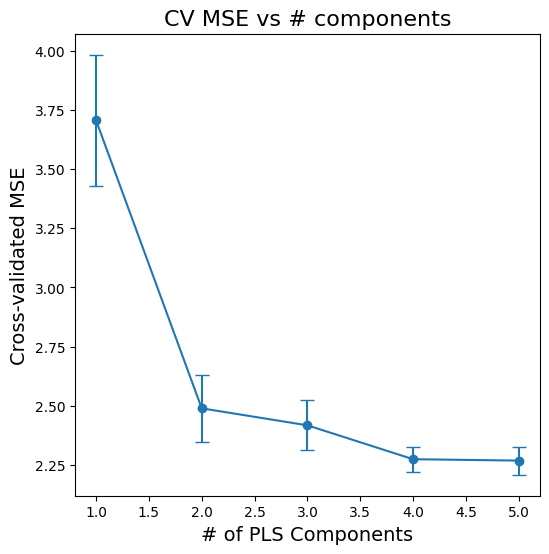

In [3]:
df = pd.read_excel("synthesized_data.xlsx")

X_cols = ['acetate_mM', 'glucose_g_L', 'mg_mM', 'nh3_mM', 'phosphate_mM']

bem_model, pls_scores_df_train = train_bem_pls_for_scores(
    df,
    batch_prefix='S1',
    batch_col='batch_id',
    time_col='batch_time_h',
    X_cols=X_cols,
    y_col=['batch_time_h'],   # how you're using it now
)

In [19]:
# Training-only visualization
plot_component_with_bounds(
    bem_model["X_T_train"],
    bem_model["summary_df"],
    components=3
)

printintg component 1


printintg component 2


printintg component 3


[Figure({
     'data': [{'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_001</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_001',
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
                     22.0, 23.0, 24.0],
               'y': {'bdata': ('QX3QtBj2+79p24RwxIj5v6AVLQ7jhf' ... 'fDpjUBQFMzGvMuEgJASvb1yQ2/AUA='),
                     'dtype': 'f8'}},
              {'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_002</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_002',
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
                     22.0, 23

In [21]:
def transform_new_batches_to_scores(df_new, model):
    """
    Use an already-trained BEM PLS model to compute scores and batch-level matrix
    for new/incomplete batches.
    """
    batch_col = model["batch_col"]
    time_col = model["time_col"]
    X_cols = model["X_cols"]
    scaler_X = model["scaler_X"]
    pls_scores = model["pls_scores"]

    # 1. build df_model for new data
    df_model_new = df_new[[time_col, batch_col] + X_cols].copy()
    df_model_new = df_model_new.sort_values([batch_col, time_col])

    X_new = df_model_new[X_cols].to_numpy()
    X_new_scaled = scaler_X.transform(X_new)   # IMPORTANT: transform, not fit_transform

    # 2. score using existing PLS
    T_new = pls_scores.transform(X_new_scaled)
    score_cols = model["score_cols"]

    T_new_df = pd.DataFrame(T_new, columns=score_cols, index=df_model_new.index)

    pls_scores_df_new = pd.concat(
        [df_model_new[[time_col, batch_col]].reset_index(drop=True),
         T_new_df.reset_index(drop=True)],
        axis=1
    )

    # 3. batch-level matrix for new batches
    X_T_new = make_batch_level_matrix_pandas(
        pls_scores_df_new,
        batch_col=batch_col,
        time_col=time_col,
        comp_prefix='comp_'
    )

    # 4. align columns to training matrix (fill missing with NaN)
    X_T_train = model["X_T_train"]
    X_T_new_aligned = X_T_new.reindex(columns=X_T_train.columns, fill_value=np.nan)

    return pls_scores_df_new, X_T_new_aligned

In [29]:
#df_new = pd.read_excel("new_batch_incomplete_deviation.xlsx")  # whatever new source
df_new = pd.read_excel("new_batch_incomplete.xlsx")  # whatever new source

pls_scores_df_new, X_T_new = transform_new_batches_to_scores(df_new, bem_model)

# Training + new batches
plot_component_with_bounds(
    bem_model["X_T_train"],
    bem_model["summary_df"],
    components=2,
    X_T_new=X_T_new
)

printing component 1


printing component 2


[Figure({
     'data': [{'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_001</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_001',
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
                     22.0, 23.0, 24.0],
               'y': {'bdata': ('QX3QtBj2+79p24RwxIj5v6AVLQ7jhf' ... 'fDpjUBQFMzGvMuEgJASvb1yQ2/AUA='),
                     'dtype': 'f8'}},
              {'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_002</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_002',
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
                     22.0, 23

## Part 2 - Batch Evolution Modeling

In [ ]:
#reorganize matrix to  Nx(AxJ) via melt and pivot
def make_batch_level_matrix_pandas(pls_scores_df,
                                   batch_col='batch_id',
                                   time_col='batch_time_h',
                                   comp_prefix='comp_'):
    # 1) find component columns
    comp_cols = [c for c in pls_scores_df.columns if c.startswith(comp_prefix)]

    # 2) melt to long: one row per (batch, time, component)
    long = pls_scores_df.melt(
        id_vars=[batch_col, time_col],
        value_vars=comp_cols,
        var_name='component',
        value_name='score'
    )

    # 3) pivot: rows = batch, columns = (component, time)
    wide = (
        long
        .pivot(index=batch_col, columns=['component', time_col], values='score')
        .sort_index(axis=1, level=[0, 1])
    )

    # 4) optionally flatten MultiIndex columns -> comp_1_0.0, comp_1_1.0, ...
    wide.columns = [f"{comp}_{t}" for (comp, t) in wide.columns]

    return wide
X_T_df = make_batch_level_matrix_pandas(pls_scores_df)
print(X_T_df.shape)   # N x (A*J)
print(X_T_df.head())

(17, 50)
            comp_1_0  comp_1_1  comp_1_2  comp_1_3  comp_1_4  comp_1_5  \
batch_id                                                                 
S1_syn_001 -1.747582 -1.595890 -1.532687 -1.454071 -1.449703 -1.415352   
S1_syn_002 -2.108664 -2.139138 -2.111507 -2.200045 -2.191990 -2.164709   
S1_syn_003 -2.116204 -2.162861 -2.049186 -2.146566 -2.030741 -1.993775   
S1_syn_004 -1.482896 -1.446559 -1.446904 -1.490590 -1.522649 -1.304107   
S1_syn_005 -2.669822 -2.492182 -2.418752 -2.176700 -2.041409 -1.835693   

            comp_1_6  comp_1_7  comp_1_8  comp_1_9  ...  comp_2_15  comp_2_16  \
batch_id                                            ...                         
S1_syn_001 -1.228802 -1.245147 -1.035664 -0.816495  ...  -0.308307  -0.330485   
S1_syn_002 -1.985662 -1.859208 -1.578412 -1.492036  ...   0.239271   0.076749   
S1_syn_003 -1.639242 -1.515866 -1.370681 -1.360451  ...   1.157124   0.894327   
S1_syn_004 -1.078282 -0.778784 -0.844721 -0.442547  ...  -0.480407 

In [ ]:
#calculate average, standard deviations for each column.
#calculate upper and lower limits

mean_row=X_T_df.mean(axis=0)
std_row=X_T_df.std(axis=0)
upper_limit_row=mean_row+3*std_row
lower_limit_row=mean_row-3*std_row

summary_df = pd.DataFrame(
    [mean_row, std_row, upper_limit_row, lower_limit_row],
    index=['mean', 'std', 'upper_3sd','lower_3sd']
)

X_T_with_stats = pd.concat([X_T_df, summary_df], axis=0)
print(X_T_with_stats.tail())


            comp_1_0  comp_1_1  comp_1_2  comp_1_3  comp_1_4  comp_1_5  \
S1_syn_017 -2.530839 -2.427321 -2.378374 -2.181016 -2.090589 -2.032885   
mean       -1.935981 -1.904058 -1.892709 -1.844247 -1.769698 -1.651286   
std         0.447914  0.414205  0.395207  0.373841  0.396682  0.398060   
upper_3sd  -0.592240 -0.661442 -0.707088 -0.722723 -0.579652 -0.457105   
lower_3sd  -3.279723 -3.146674 -3.078330 -2.965770 -2.959744 -2.845467   

            comp_1_6  comp_1_7  comp_1_8  comp_1_9  ...  comp_2_15  comp_2_16  \
S1_syn_017 -1.734801 -1.690426 -1.415786 -1.030434  ...   0.133352  -0.182678   
mean       -1.518404 -1.331187 -1.131952 -0.968836  ...   0.346797   0.209125   
std         0.354192  0.374279  0.329528  0.360337  ...   0.553392   0.514404   
upper_3sd  -0.455827 -0.208351 -0.143369  0.112176  ...   2.006973   1.752336   
lower_3sd  -2.580980 -2.454023 -2.120534 -2.049848  ...  -1.313379  -1.334086   

            comp_2_17  comp_2_18  comp_2_19  comp_2_20  comp_2_21  c

In [ ]:
#Visualize

def plot_component_with_bounds(X_T_df, component='comp_1'):
    """
    Plot a selected PLS component for each batch over time, plus mean ± 3*SD bounds.

    Parameters
    ----------
    X_T_df : pd.DataFrame
        Rows = batches (and possibly summary rows like 'mean', 'std', etc.).
        Columns = features like 'comp_1_t0.0', 'comp_1_t1.0', ...
    component : str, default 'comp_1'
        Which component to plot (prefix of column names).
    """

    # --- 1. Filter out any summary rows if they exist ---
    summary_labels = {'mean', 'std', 'upper_3sd', 'lower_3sd'}
    df_batches = X_T_df.loc[~X_T_df.index.isin(summary_labels)].copy()

    # --- 2. Select columns for the chosen component ---
    comp_cols = [c for c in df_batches.columns if c.startswith(component)]
    if not comp_cols:
        raise ValueError(f"No columns found for component '{component}'")

    # --- 3. Extract times from column names and sort ---
    def extract_time(col):
        # If your columns look like 'comp_1_t0.0':
        if '_t' in col:
            time_str = col.split('_t')[-1]
        else:
            # If instead you use 'comp_1_0.0', uncomment this line and adjust:
            # time_str = col.split(component)[-1].lstrip('_')
            time_str = col.split(component)[-1].lstrip('_')
        return float(time_str)

    times_and_cols = [(extract_time(c), c) for c in comp_cols]
    times_and_cols.sort(key=lambda x: x[0])
    times = [t for t, _ in times_and_cols]
    sorted_cols = [c for _, c in times_and_cols]

    # Subset in the correct time order
    comp_matrix = df_batches[sorted_cols]

    # --- 4. Compute bounds: mean ± 3*SD across batches for each timepoint ---
    mean_vals = comp_matrix.mean(axis=0)
    std_vals = comp_matrix.std(axis=0)
    upper_vals = mean_vals + 3 * std_vals
    lower_vals = mean_vals - 3 * std_vals

    # --- 5. Build Plotly figure ---
    fig = go.Figure()

    # Add one trace per batch
    for batch_id, row in comp_matrix.iterrows():
        fig.add_trace(
            go.Scatter(
                x=times,
                y=row.values,
                mode='lines',
                name=str(batch_id),
                hovertemplate='time: %{x}<br>score: %{y}<extra>' + str(batch_id) + '</extra>',
            )
        )

    # Add upper bound
    fig.add_trace(
        go.Scatter(
            x=times,
            y=upper_vals.values,
            mode='lines',
            name='upper (mean + 3·SD)',
            line=dict(dash='dot'),
            hovertemplate='time: %{x}<br>upper: %{y}<extra></extra>',
        )
    )

    # Add lower bound
    fig.add_trace(
        go.Scatter(
            x=times,
            y=lower_vals.values,
            mode='lines',
            name='lower (mean - 3·SD)',
            line=dict(dash='dot'),
            hovertemplate='time: %{x}<br>lower: %{y}<extra></extra>',
        )
    )

    fig.update_layout(
        title=f"{component} scores over time (per batch) with ±3·SD bounds",
        xaxis_title="Time (h)",
        yaxis_title=f"{component} score",
        legend_title="Batch / Bounds",
    )

    fig.show()
    return fig
# For component 1
plot_component_with_bounds(X_T_df, component='comp_1')

## Part 3 Batch Level Modeling

In [43]:
##join X_T_df with meta_cols and output_cols
df_combined=X_T_df.merge(df_batch, left_on='batch_id',right_on=['batch_id'])
df_combined.head()


,batch_id,comp_1_0,comp_1_1,comp_1_2,comp_1_3,comp_1_4,comp_1_5,comp_1_6,comp_1_7,comp_1_8,...,comp_2_19,comp_2_20,comp_2_21,comp_2_22,comp_2_23,comp_2_24,solution_type,Method,Site,titer_mg_mL
0,S1_syn_001,-1.747582,-1.595890,-1.532687,-1.454071,-1.449703,-1.415352,-1.228802,-1.245147,-1.035664,...,-0.482710,-0.688362,-0.711762,-0.752237,-0.839900,-0.731515,1,1,1,0.398551
1,S1_syn_002,-2.108664,-2.139138,-2.111507,-2.200045,-2.191990,-2.164709,-1.985662,-1.859208,-1.578412,...,-0.604945,-0.789453,-0.947076,-1.198413,-1.146850,-1.083822,1,1,1,0.445472
2,S1_syn_003,-2.116204,-2.162861,-2.049186,-2.146566,-2.030741,-1.993775,-1.639242,-1.515866,-1.370681,...,0.659416,0.538000,0.455988,0.582360,0.517225,0.584191,1,1,1,0.447912
3,S1_syn_004,-1.482896,-1.446559,-1.446904,-1.490590,-1.522649,-1.304107,-1.078282,-0.778784,-0.844721,...,-1.031844,-1.097241,-1.069145,-1.150643,-1.151901,-0.678923,1,1,1,0.446373
4,S1_syn_005,-2.669822,-2.492182,-2.418752,-2.176700,-2.041409,-1.835693,-1.841302,-1.588997,-1.326848,...,0.245282,0.012284,0.006833,-0.074625,-0.166262,-0.244833,1,1,1,0.481636


X shape: (17, 52)


C:\Users\jhuang\AppData\Local\Temp\ipykernel_21016\326824975.py:32: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



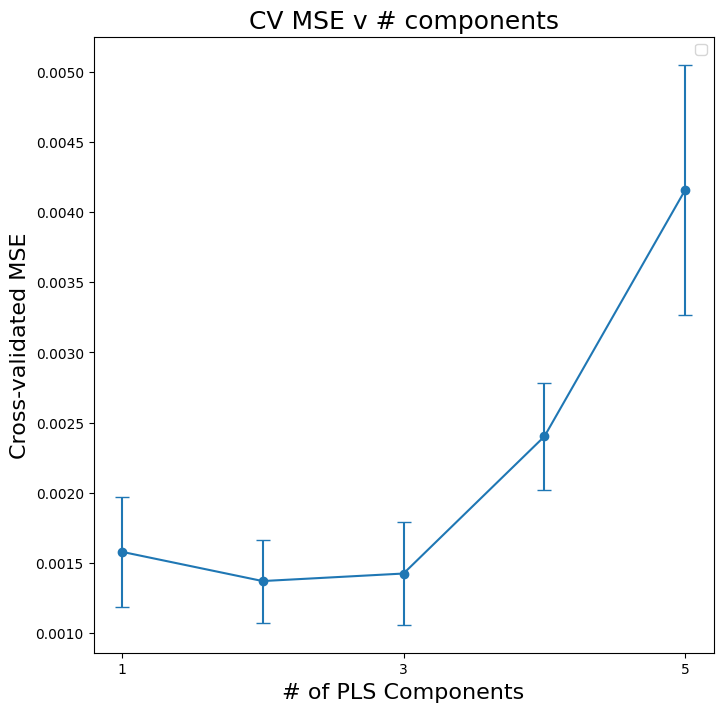

In [48]:
#PLS Model with X,Z stacked, predicting on Y
meta_cols=['batch_id','solution_type']
y_col=['titer_mg_mL']
exclude_cols=meta_cols+y_col
X=df_combined.drop(columns=exclude_cols).to_numpy()
y=df_combined[y_col]
print("X shape:", X.shape)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)

pls = PLSRegression()

param_grid = {'n_components':range(1, len(X_cols)+1)}
grid = skm.GridSearchCV(pls ,param_grid ,cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_scaled, y)

# Extract results
mean_mse = -grid.cv_results_['mean_test_score']
std_mse = grid.cv_results_['std_test_score'] / np.sqrt(K)
optimal_n_components = grid.best_params_['n_components']

# Plot Cross-Validated MSE vs. # of PLS Components
plt.figure(figsize=(8, 8))
plt.errorbar(param_grid['n_components'], mean_mse, yerr=std_mse, fmt='o-', capsize=5)
plt.ylabel("Cross-validated MSE", fontsize=16)
plt.xlabel("# of PLS Components", fontsize=16)
plt.xticks(list(param_grid['n_components'])[::2])  # Show every other tick
plt.title("CV MSE v # components", fontsize=18)
plt.legend()
plt.show()

In [ ]:
#get T matrix, scores
n_comp = 2
pls_3 = PLSRegression(n_components=n_comp)
pls_3.fit(X_scaled, y)

### additional steps

Include 'deviation' batch

How to incorporate 2nd solution type

Include Time difference samples (interpolation?)

## Batch in Progress

In [ ]:

#load completed batches (good batches)
#generate df_model, and X
#select model n_componenents
#generate scores (T) through PLS_1
#convert to T_df
#Rearrange to X_T
#Calculate means and intervals.
#Plot

#load incomplete batch.
#generate df_model
#generate scores (T) through PLS_1.
#convert to T_df
#Rearrange to X_T
#Plot in conjunction to evaluate the BEM current.

